In [40]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
class DualLayer:
    
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.units = units
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
       
    def init_weights(self, x):
        self.w1 = np.ones((x.shape[1], self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.ones((self.units, 1))
        self.b2 = 0
        
    def activation(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a
        
    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.activation(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2
    
    def backprop(self, x, err):
        m = len(x)
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        hidden_to_err = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        w1_grad = np.dot(x.T, hidden_to_err) / m
        b1_grad = np.sum(hidden_to_err, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))
    
    def update_val_losses(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))
     
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        self.init_weights(x)
        m = len(x)
        for i in tqdm(range(epochs)):
            z = self.forpass(x)
            a = self.activation(z)
            err = - (y - a)
            w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
            w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
            w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
            self.w1 -= self.lr * w1_grad
            self.b1 -= self.lr * b1_grad
            self.w2 -= self.lr * w2_grad
            self.b2 -= self.lr * b2_grad
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.update_val_losses(x_val, y_val)
            
    def predict(self, x):
        z = self.forpass(x)
        return z > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y.reshape(-1, 1))    

In [4]:
class RandomInitNetwork(DualLayer):
    
    def init_weights(self, x):
        np.random.seed(seed=42)
        self.w1 = np.random.normal(0, 1, (x.shape[1], self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0, 1, (self.units, 1))
        self.b2 = 0

In [5]:
class MinibatchNetwork(RandomInitNetwork):
    
    def __init__(self, units=10, batch_size=32,learning_rate=0.1, l1=0, l2=0):
        super().__init__(units, learning_rate, l1, l2)
        self.batch_size = batch_size
            
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size
        if length % self.batch_size:
            bins += 1
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y_val = y_val.reshape(-1, 1)
        self.init_weights(x)
        np.random.seed(42)
        for i in tqdm(range(epochs)):
            loss = 0
            for x_batch, y_batch in self.gen_batch(x, y):
                m = len(x_batch)
                
                y_batch = y_batch.reshape(-1, 1)
                
                z = self.forpass(x_batch)
                a = self.activation(z)
                err = - (y_batch - a)

                w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x_batch, err)

                w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
                w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m

                self.w1 -= self.lr * w1_grad
                self.b1 -= self.lr * b1_grad

                self.w2 -= self.lr * w2_grad
                self.b2 -= self.lr * b2_grad

                a = np.clip(a, 1e-10, 1-1e-10)

                loss += np.sum(- (y_batch * np.log(a) + (1 - y_batch) * np.log(1 - a)))
            
            self.losses.append((loss + self.reg_loss()) / len(x))
            self.update_val_losses(x_val, y_val)
            
    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))
    
    def update_val_losses(self, x_val, y_val):
        z2 = self.forpass(x_val)
        a2 = self.activation(z2)
        a2 = np.clip(a2, 1e-10, 1-1e-10)
        val_loss = np.sum(- (y_val * np.log(a2) + (1 - y_val) * np.log(1 - a2)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [6]:
class MiniClassNetwork():
    
    def __init__(self, units=10, batch_size=32,learning_rate=0.1, l1=0, l2=0):
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.units = units
        self.batch_size = batch_size
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
       
    def init_weights(self, x, y):
        np.random.seed(seed=42)
        self.w1 = np.random.normal(0, 1, (x.shape[1], self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0, 1, (self.units, y.shape[1]))
        self.b2 = 0
        
    def sigmoid(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a
    
    def softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / np.sum(np.exp(z), axis=1).reshape(-1, 1)
        
    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.sigmoid(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2
    
    def backprop(self, x, err):
        m = len(x)
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        hidden_to_err = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        w1_grad = np.dot(x.T, hidden_to_err) / m
        b1_grad = np.sum(hidden_to_err, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))
    
    def update_val_losses(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.softmax(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(- y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))
        
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size
        if length % self.batch_size:
            bins += 1
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]
     
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x, y)
        np.random.seed(42)
        for i in range(epochs):
            print('.', end='')
            loss = 0
            for x_batch, y_batch in self.gen_batch(x, y):
                m = len(x_batch)
                
                z = self.forpass(x_batch)
                a = self.softmax(z)
                err = - (y_batch - a)

                w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x_batch, err)

                w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
                w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m

                self.w1 -= self.lr * w1_grad
                self.b1 -= self.lr * b1_grad

                self.w2 -= self.lr * w2_grad
                self.b2 -= self.lr * b2_grad

                a = np.clip(a, 1e-10, 1-1e-10)

                loss += np.sum(- y_batch * np.log(a))
            
            self.losses.append((loss + self.reg_loss()) / len(x))
            self.update_val_losses(x_val, y_val)
            
    def predict(self, x):
        z = self.forpass(x)
        return np.argmax(z, axis=1)
    
    def score(self, x, y):
        return np.mean(self.predict(x) == np.argmax(y, axis=1))    
    

In [7]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [8]:
print("The number of train images: %s" % len(train_images))
print("The number of test images: %s" % len(test_images))

The number of train images: 60000
The number of test images: 10000


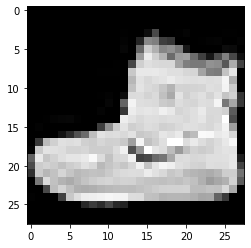

In [9]:
plt.imshow(train_images[0], cmap='gray')
plt.show()

In [10]:
train_labels[0]

9

In [11]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [12]:
class_names[train_labels[0]]

'Ankle boot'

In [13]:
np.bincount(train_labels)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, stratify=train_labels, test_size=0.2, random_state=42)

In [16]:
print("The number of train images: %d" % len(x_train))
print("The number of validation images: %d" % len(x_val))

The number of train images: 48000
The number of validation images: 12000


In [17]:
x_train = x_train / 255
x_val = x_val / 255

In [18]:
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

print("The shape of train dataset: %d" % x_train.shape[1])
print("The shape of validation dataset: %d" % x_val.shape[1])

The shape of train dataset: 784
The shape of validation dataset: 784


In [19]:
y_train_encoded = keras.utils.to_categorical(y_train)
y_val_encoded = keras.utils.to_categorical(y_val)

In [20]:
fc = MiniClassNetwork(units=100, batch_size=256)
fc.fit(x_train,
       y_train_encoded,
       epochs=40,
       x_val=x_val,
       y_val=y_val_encoded)

........................................

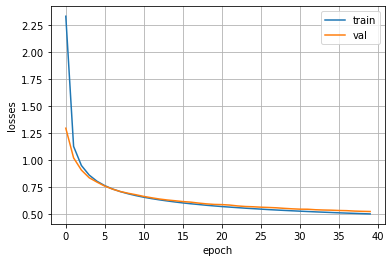

In [21]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel("losses")
plt.xlabel("epoch")
plt.legend(["train", "val"])
plt.grid()
plt.show()

In [29]:
score = fc.score(x_val, y_val_encoded)
print("The accuracy: %s" % score)

The accuracy: 0.8150833333333334


### CNN

In [48]:
class ConvolutionNetwork():
    
    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels
        self.kernel_size = 3
        self.optimizer = None
        self.conv_w = None
        self.conv_b = None
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.units = units
        self.batch_size = batch_size
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
       
    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)
        self.w2 = tf.Variable(g((self.units, n_classes)))
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)
        
    def sigmoid(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a
    
    def softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / np.sum(np.exp(z), axis=1).reshape(-1, 1)
        
    def forpass(self, x):
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        r_out = tf.nn.relu(c_out)
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1
        a1 = tf.nn.relu(z1)
        z2 = tf.matmul(a1, self.w2) + self.b2
        return z2
    
    def training(self, x, y):
        m = len(x)
        with tf.GradientTape() as tape:
            z = self.forpass(x)
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)
            weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2]
            grads = tape.gradient(loss, weights_list)
            self.optimizer.apply_gradients(zip(grads, weights_list))
        
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size
        if length % self.batch_size:
            bins += 1
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]
            
    def get_loss(self, x, y):
        z = self.forpass(x)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()
     
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        np.random.seed(42)
        for i in range(epochs):
            print('에포크', i, end=' ')
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch)
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            self.losses.append(np.mean(batch_losses))
            self.val_losses.append(self.get_loss(x_val, y_val))
            
    def predict(self, x):
        z = self.forpass(x)
        return np.argmax(z, axis=1)
    
    def score(self, x, y):
        return np.mean(self.predict(x) == np.argmax(y, axis=1))    
    

In [35]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

print(x_train.shape)
print(x_val.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)


In [49]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, epochs=20, x_val=x_val, y_val=y_val_encoded)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

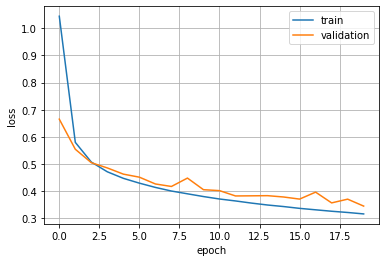

In [52]:
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.legend(["train", "validation"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()

In [54]:
cn.score(x_val, y_val_encoded)

0.8828333333333334